In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install required packages
!pip install torch torchcrf transformers tqdm pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
# Set up paths (adjust these paths based on your actual file structure in Colab)
import os
import sys
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import get_scheduler

In [3]:
!pip install pytorch-crf

In [4]:
# Add the project root to Python path for imports
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_score"  # Change this if your files are in a different location
sys.path.append(PROJECT_DIR)

# Import the necessary modules
from dataset.dataset import get_dataloaders
from Models.xlm_roberta_improved import XLMRobertaForIdiomDetection, train_model, predict_idioms, evaluate

# Define paths
DATA_DIR = os.path.join(PROJECT_DIR, "dataset")
MODELS_DIR = os.path.join(PROJECT_DIR, "Models")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "Submissions")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "Models/saved_models"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "Models/results"), exist_ok=True)

In [5]:
# Function to run experiment and track results
def run_organized_experiment(batch_size=16, lr=1e-5, max_length=128, epochs=3):
    experiment_name = f"xlm_bs{batch_size}_lr{lr}_ml{max_length}_ep{epochs}"
    model_save_path = os.path.join(PROJECT_DIR, "Models/saved_models", f"{experiment_name}.pt")
    results_save_path = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_metrics.csv")
    fig_save_path = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_plot.png")

    # Initialize results tracking
    results = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Initialize tokenizer
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

    print(f"\nRunning experiment: {experiment_name}")
    print("Loading data...")

    # Get data loaders
    train_loader, val_loader, _ = get_dataloaders(
        train_path=os.path.join(DATA_DIR, 'train.csv'),
        val_path=os.path.join(DATA_DIR, 'eval.csv'),
        batch_size=batch_size,
        max_length=max_length,
        tokenizer=tokenizer
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = XLMRobertaForIdiomDetection()
    model.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    best_f1 = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in progress_bar:
            if batch['input_ids'].size(0) == 0:
                continue

            train_batches += 1
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Evaluation
        print("Evaluating...")
        metrics = evaluate(model, val_loader, tokenizer, device)

        # Store metrics
        results['epoch'].append(epoch + 1)
        results['train_loss'].append(avg_train_loss)
        results['val_loss'].append(metrics['val_loss'])
        results['precision'].append(metrics['precision'])
        results['recall'].append(metrics['recall'])
        results['f1'].append(metrics['f1'])

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {metrics['val_loss']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")

        # Save best model
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with F1: {best_f1:.4f}")

    # Save metrics to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(results_save_path, index=False)
    print(f"Results saved to {results_save_path}")

    # Plot results
    plt.figure(figsize=(12, 10))

    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(results['epoch'], results['train_loss'], 'b-', marker='o', label='Training Loss')
    plt.plot(results['epoch'], results['val_loss'], 'r-', marker='o', label='Validation Loss')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot metrics
    plt.subplot(2, 1, 2)
    plt.plot(results['epoch'], results['precision'], 'g-', marker='o', label='Precision')
    plt.plot(results['epoch'], results['recall'], 'b-', marker='o', label='Recall')
    plt.plot(results['epoch'], results['f1'], 'r-', marker='o', label='F1 Score')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    plt.title('Model Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(fig_save_path)
    print(f"Plot saved to {fig_save_path}")
    plt.show()

    # Load best model for predictions
    best_model = XLMRobertaForIdiomDetection()
    best_model.load_state_dict(torch.load(model_save_path))
    best_model.to(device)

    # Generate predictions
    prediction_file = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_predictions.csv")
    generate_predictions(best_model, tokenizer, device, prediction_file)

    return {
        'model_path': model_save_path,
        'results_path': results_save_path,
        'fig_path': fig_save_path,
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'final_metrics': {
            'precision': results['precision'][-1],
            'recall': results['recall'][-1],
            'f1': results['f1'][-1]
        }
    }


In [6]:
# Function to generate predictions
def generate_predictions(model, tokenizer, device, output_file):
    print("Generating predictions...")
    model.eval()

    # Read test data
    test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_w_o_labels.csv'))
    ids = test_df['id'].tolist()
    languages = test_df['language'].tolist()
    sentences = test_df['sentence'].tolist()

    # Generate predictions
    results = []
    for idx, sentence, lang in tqdm(zip(ids, sentences, languages), total=len(ids)):
        _, idiom_indices = predict_idioms(model, tokenizer, sentence, device)
        # If no idiom, output [-1] as in training
        if not idiom_indices:
            idiom_indices = [-1]
        results.append({'id': idx, 'indices': str(idiom_indices), 'language': lang})

    # Save predictions
    out_df = pd.DataFrame(results)
    out_df.to_csv(output_file, index=False)
    print(f'Predictions saved to {output_file}')

    return out_df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]


Running experiment: xlm_bs16_lr1e-05_ml128_ep15
Loading data...


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Epoch 1/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.24it/s, loss=4.6621]


Average training loss: 8.0376
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.24it/s]


Epoch 1/15:
  Train Loss: 8.0376
  Val Loss: 3.7852
  Precision: 0.8491
  Recall: 0.4997
  F1 Score: 0.2421
New best model saved with F1: 0.2421


Epoch 2/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=3.2973]


Average training loss: 3.0612
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 2/15:
  Train Loss: 3.0612
  Val Loss: 2.3592
  Precision: 0.7681
  Recall: 0.8795
  F1 Score: 0.4470
New best model saved with F1: 0.4470


Epoch 3/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.25it/s, loss=2.7831]


Average training loss: 2.0464
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 3/15:
  Train Loss: 2.0464
  Val Loss: 2.2102
  Precision: 0.9152
  Recall: 0.8410
  F1 Score: 0.4378


Epoch 4/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.1768]


Average training loss: 1.5350
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 4/15:
  Train Loss: 1.5350
  Val Loss: 1.8899
  Precision: 0.9054
  Recall: 0.8504
  F1 Score: 0.4492
New best model saved with F1: 0.4492


Epoch 5/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.9335]


Average training loss: 1.2920
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 5/15:
  Train Loss: 1.2920
  Val Loss: 1.6009
  Precision: 0.9299
  Recall: 0.8888
  F1 Score: 0.4625
New best model saved with F1: 0.4625


Epoch 6/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.25it/s, loss=2.7478]


Average training loss: 1.1221
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.27it/s]


Epoch 6/15:
  Train Loss: 1.1221
  Val Loss: 1.5415
  Precision: 0.9232
  Recall: 0.9174
  F1 Score: 0.4780
New best model saved with F1: 0.4780


Epoch 7/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.24it/s, loss=2.5713]


Average training loss: 0.9850
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Epoch 7/15:
  Train Loss: 0.9850
  Val Loss: 1.8736
  Precision: 0.9218
  Recall: 0.9366
  F1 Score: 0.4858
New best model saved with F1: 0.4858


Epoch 8/15 [Training]: 100%|██████████| 720/720 [05:21<00:00,  2.24it/s, loss=0.9719]


Average training loss: 0.8496
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.24it/s]


Epoch 8/15:
  Train Loss: 0.8496
  Val Loss: 2.0367
  Precision: 0.8993
  Recall: 0.9325
  F1 Score: 0.4848


Epoch 9/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.0084]


Average training loss: 0.7465
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 9/15:
  Train Loss: 0.7465
  Val Loss: 1.9876
  Precision: 0.9063
  Recall: 0.9392
  F1 Score: 0.4886
New best model saved with F1: 0.4886


Epoch 10/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.25it/s, loss=0.0058]


Average training loss: 0.6732
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Epoch 10/15:
  Train Loss: 0.6732
  Val Loss: 2.2857
  Precision: 0.9092
  Recall: 0.9418
  F1 Score: 0.4888
New best model saved with F1: 0.4888


Epoch 11/15 [Training]: 100%|██████████| 720/720 [05:20<00:00,  2.25it/s, loss=2.8245]


Average training loss: 0.5573
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Epoch 11/15:
  Train Loss: 0.5573
  Val Loss: 2.3316
  Precision: 0.9164
  Recall: 0.9397
  F1 Score: 0.4871


Epoch 12/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.0044]


Average training loss: 0.5165
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.24it/s]


Epoch 12/15:
  Train Loss: 0.5165
  Val Loss: 2.2252
  Precision: 0.9234
  Recall: 0.9397
  F1 Score: 0.4879


Epoch 13/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.0035]


Average training loss: 0.4303
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Epoch 13/15:
  Train Loss: 0.4303
  Val Loss: 2.3960
  Precision: 0.9110
  Recall: 0.9408
  F1 Score: 0.4882


Epoch 14/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=1.0043]


Average training loss: 0.3888
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Epoch 14/15:
  Train Loss: 0.3888
  Val Loss: 2.3245
  Precision: 0.9184
  Recall: 0.9418
  F1 Score: 0.4879


Epoch 15/15 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=0.0018]


Average training loss: 0.3510
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch 15/15:
  Train Loss: 0.3510
  Val Loss: 2.3746
  Precision: 0.9161
  Recall: 0.9413
  F1 Score: 0.4876
Results saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep15_metrics.csv
Plot saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep15_plot.png


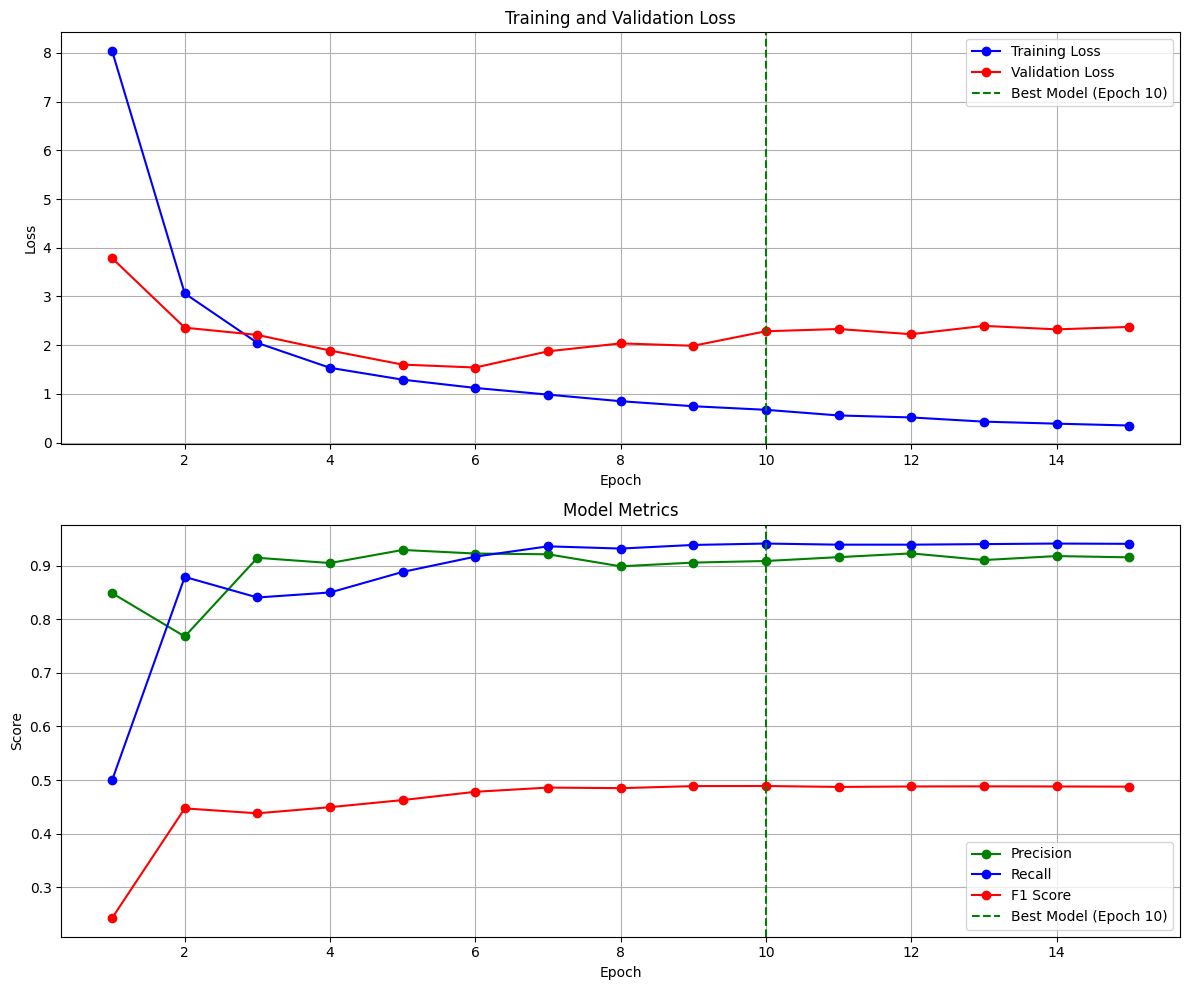

Generating predictions...


100%|██████████| 1435/1435 [00:55<00:00, 25.84it/s]


Predictions saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep15_predictions.csv

Experiment complete!
Best F1 Score: 0.4888 (Epoch 10)
Model saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/saved_models/xlm_bs16_lr1e-05_ml128_ep15.pt
Metrics saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep15_metrics.csv
Plot saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep15_plot.png


In [7]:
# Run a single experiment with desired parameters
result = run_organized_experiment(batch_size=16, lr=1e-05, max_length=128, epochs=15)

print("\nExperiment complete!")
print(f"Best F1 Score: {result['best_f1']:.4f} (Epoch {result['best_epoch']})")
print(f"Model saved to: {result['model_path']}")
print(f"Metrics saved to: {result['results_path']}")
print(f"Plot saved to: {result['fig_path']}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]


Running experiment: xlm_bs16_lr1e-05_ml128_ep3
Loading data...


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Epoch 1/3 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.26it/s, loss=2.7818]


Average training loss: 5.6336
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.28it/s]


Epoch 1/3:
  Train Loss: 5.6336
  Val Loss: 2.8740
  Precision: 0.7457
  Recall: 0.8483
  F1 Score: 0.4288
New best model saved with F1: 0.4288


Epoch 2/3 [Training]: 100%|██████████| 720/720 [05:18<00:00,  2.26it/s, loss=1.2105]


Average training loss: 2.4717
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.23it/s]


Epoch 2/3:
  Train Loss: 2.4717
  Val Loss: 2.1523
  Precision: 0.8034
  Recall: 0.9127
  F1 Score: 0.4592
New best model saved with F1: 0.4592


Epoch 3/3 [Training]: 100%|██████████| 720/720 [05:19<00:00,  2.25it/s, loss=1.8469]


Average training loss: 1.8128
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:27<00:00,  3.28it/s]


Epoch 3/3:
  Train Loss: 1.8128
  Val Loss: 1.8891
  Precision: 0.8612
  Recall: 0.8862
  F1 Score: 0.4501
Results saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep3_metrics.csv
Plot saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep3_plot.png


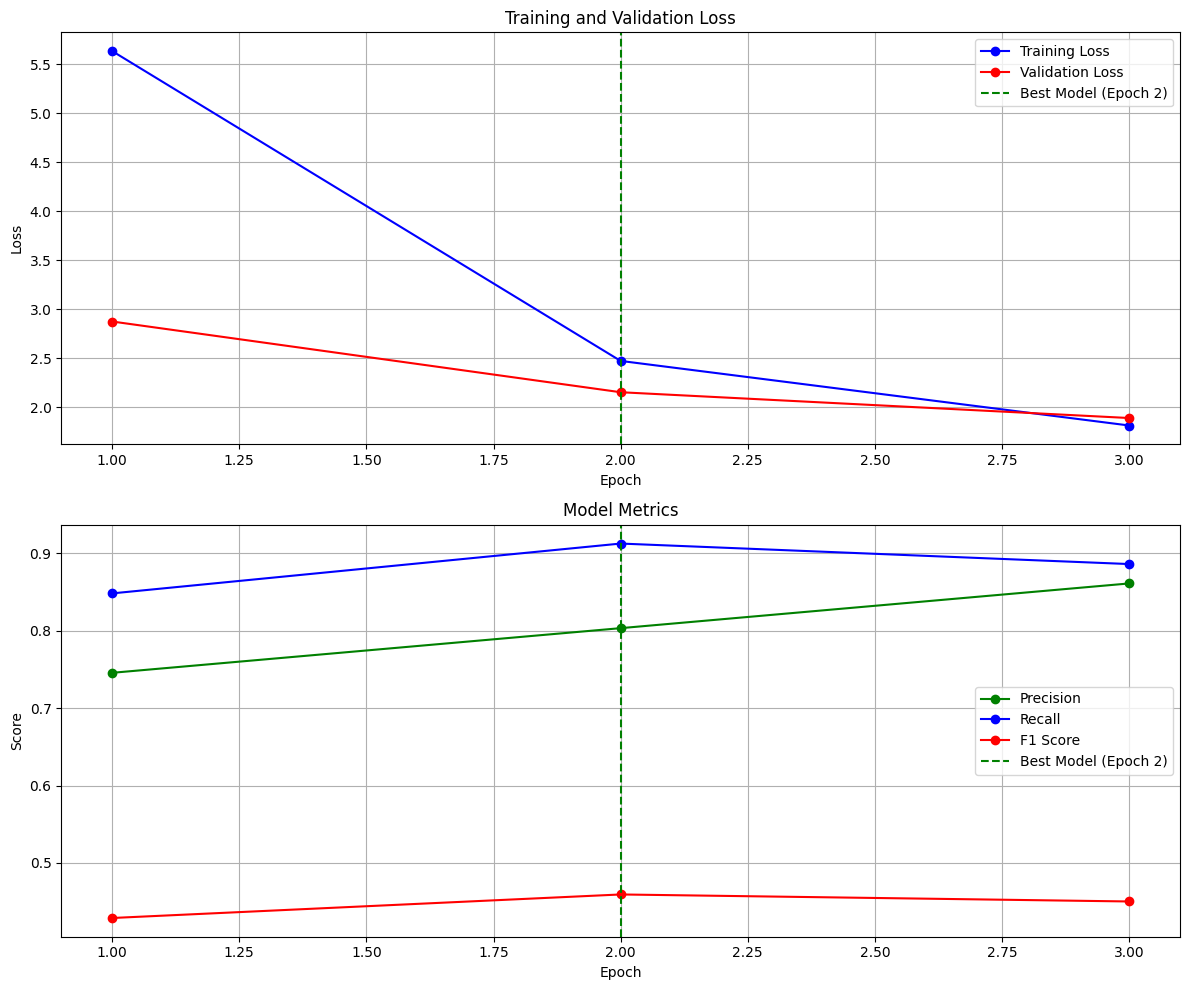

Generating predictions...


100%|██████████| 1435/1435 [00:54<00:00, 26.18it/s]


Predictions saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep3_predictions.csv

Experiment complete!
Best F1 Score: 0.4592 (Epoch 2)
Model saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/saved_models/xlm_bs16_lr1e-05_ml128_ep3.pt
Metrics saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep3_metrics.csv
Plot saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_score/Models/results/xlm_bs16_lr1e-05_ml128_ep3_plot.png


In [ ]:
# Run a single experiment with desired parameters
result = run_organized_experiment(batch_size=16, lr=1e-5, max_length=128, epochs=3)

print("\nExperiment complete!")
print(f"Best F1 Score: {result['best_f1']:.4f} (Epoch {result['best_epoch']})")
print(f"Model saved to: {result['model_path']}")
print(f"Metrics saved to: {result['results_path']}")
print(f"Plot saved to: {result['fig_path']}")

In [ ]:
# Optional: Test the model with a single example
def test_single_example():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

    model = XLMRobertaForIdiomDetection()
    model.load_state_dict(torch.load('best_xlm_roberta_idiom_model.pt', map_location=device))
    model.to(device)

    # Example sentence from the dataset
    sentence = "Zaman öldürmek, bir tür cinayettir, Zamanınızı öldürmeyin; zamanınızı doldurun, Kıymetini bilerek zamanınızı değerlendirin."
    processed_sentence, idiom_indices = predict_idioms(model, tokenizer, sentence, device)

    print("Sentence:", sentence)
    print("Detected Idiom Indices:", idiom_indices)

    if idiom_indices:
        words = sentence.split()
        try:
            idiom_words = [words[idx] for idx in idiom_indices]
            print("Idiom Words:", " ".join(idiom_words))
        except IndexError:
            print("Warning: Index out of range. Check tokenization.")
    else:
        print("No idiom detected.")

# Uncomment to test with a single example
test_single_example()

Sentence: Zaman öldürmek, bir tür cinayettir, Zamanınızı öldürmeyin; zamanınızı doldurun, Kıymetini bilerek zamanınızı değerlendirin.
Detected Idiom Indices: [0, 1]
Idiom Words: Zaman öldürmek,
